In [1]:
# csv uznatılı dosyayı okuyabilmek için
import pandas as pd
# matris işlemleri için
import numpy as np
# opencv 
import cv2
# grafik kütüphanesi 
import matplotlib.pylab as plt
# matplotlib grafiklerini jupyter note book üzerinde göstermek için
%matplotlib inline
# rasgele sayı üretimi için
import random

In [2]:
# Eğitim için kaydettiğimiz seyir.csv dosaysını okuyoruz
df = pd.read_csv('/home/nvidia/Downloads/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/regularly/data.csv')

In [3]:
# Seyir dosaysındaki sutun başlıkları
df.columns

Index(['FileName', 'ClassId'], dtype='object')

In [4]:
# 20 den 40 kadar kayıtlar
df[20:30]

,FileName,ClassId
20,/home/nvidia/Downloads/GTSRB_Final_Training_Im...,0
21,/home/nvidia/Downloads/GTSRB_Final_Training_Im...,0
22,/home/nvidia/Downloads/GTSRB_Final_Training_Im...,0
23,/home/nvidia/Downloads/GTSRB_Final_Training_Im...,0
24,/home/nvidia/Downloads/GTSRB_Final_Training_Im...,0
25,/home/nvidia/Downloads/GTSRB_Final_Training_Im...,0
26,/home/nvidia/Downloads/GTSRB_Final_Training_Im...,0
27,/home/nvidia/Downloads/GTSRB_Final_Training_Im...,0
28,/home/nvidia/Downloads/GTSRB_Final_Training_Im...,0
29,/home/nvidia/Downloads/GTSRB_Final_Training_Im...,0


In [5]:
# Toplam kayıt sayımız
len(df)

39209

In [6]:
# Açı sutunu hakkında istatistiki bilgiler min max mean vs ...
df.ClassId.describe()

count    39209.000000
mean        15.788390
std         12.013238
min          0.000000
25%          5.000000
50%         12.000000
75%         25.000000
max         42.000000
Name: ClassId, dtype: float64

In [7]:
# Ağımızı eğitmek için  giriş verimiz resimler  çıkışımız da Açılar olacak
# bunları birer listeye aktarıyoruz
# Kamera ilk çekmeye başladığında düzgün çekemediği için başlangıçdan 30 kayıdı almıyoruz.
images = list(df.FileName[:])
labels = list(df.ClassId[:])

In [8]:
#labels

In [9]:
#labels[0]

In [10]:
type(labels[0])

int

In [11]:
# Veri setimiz ile ilgili ayarlamalar
# Veri seti küme büyüklüğü batch size
# Verisetinin ne kadarı eğitim ne kadarı test için kullanılacak
# Eğitim %80 , Test %20 
bsize = 32
dlen = len(labels)
splitpoint = int(0.8*dlen)
reindex = list(range(len(labels)))
# Eğtim verisini karıştıryoruz
random.seed(1234)
random.shuffle(reindex)

In [12]:
reindex[0:10]

[27858, 16913, 27873, 29400, 27250, 4271, 26157, 5002, 37368, 10527]

In [13]:
# ismi verilen resmi okuyup 
# rastgele olarak %50 sine parlaklık değişimi uygulayan fonksiyonu uygulayıp
# resim matrisini dönem bir fonksiyon

def get_matrix(fname):
    img = cv2.imread(fname)      
    return img

In [14]:
# Bütün veriyi hafızaya almamız mümkün değil
# Ek olarak bazen çeşitli değişimler - Augmentation - uygulamakda istiyebiliriz
# python generator ile gerektiğinde veri okunur düzenlenir ve eğitim veya test için 
# sisteme verilir
# alttaki fonksiyonlar bu işi yapar

# Generate data for training
def generate_data():
    i = 0
    while True:
        x = np.array([])
        y = []
        for j in range(i,i+bsize):  
            
            ix = reindex[j]
            img = get_matrix(images[ix])
            tempLbl = np.array(labels[ix])
            
            lbl = np.eye(43, dtype='uint8')[tempLbl]
            x = np.append(x,img)
            y.append(lbl)
            
        
        x = np.reshape(x,(-1,48,48,3))
        y = np.array(y)
       
        yield (x,y)    
        i +=bsize
        if i+bsize > splitpoint:
            i = 0
            
# Generate data for validation                  
def generate_data_val():
    i = splitpoint
    while True:
        x = np.array([])
        y = []
        for j in range(i,i+bsize): 
            
            ix = reindex[j]
            img = get_matrix(images[ix])
            tempLbl = np.array(labels[ix])
            
            lbl = np.eye(43, dtype='uint8')[tempLbl]
            x = np.append(x,img)
            y.append(lbl)
            
        x = np.reshape(x,(-1,48,48,3))
        y = np.array(y)
        
        yield (x,y)    
        i +=bsize
        if i+bsize > dlen:
            i = splitpoint

In [15]:
# Keras için gerekenler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, Cropping2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras import losses

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
# Model based on NVIDIA's End to End Learning for Self-Driving Cars model
# Sıralı bir keras modeli tanılıyoruz
model = Sequential()
# Cropping
# gelen resmin istediğimiz ksımını kırpmak için bu katmanı yazıyoruz
# Cropping2D(cropping((top_crop, bottom_crop), (left_crop, right_crop)))
# aşağıdaki satırda 
# üstten 144 alttan 76 piksel 
# soldan 0 sağdan 672 piksel kırpılıyor

#model.add(Cropping2D(cropping=((144,76),(0,672)), input_shape=(376,1344,3)))

# Normalization
# 0 - 255 arası değerler -1 ila 1 arasına çekiliyor
#model.add(Lambda(lambda x: (2*x / 255.0) - 1.0) , input_shape=(48,48,3))
# Evrişim katmanı (5, 5) lik 24 tane 2 şer piksel kayarak
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(48,48,3),activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd')        
#model.add(Conv2D(24, (5, 5), input_shape=(48,48,3), activation="relu", strides=(2, 2)))
#model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2)))
#model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2)))
# Ağın çıkışı burda vectöre çevriliyor
#model.add(Flatten())

# Yapay Sinir ağı kısmı
#model.add(Dense(100))
#model.add(Dense(25))
#model.add(Dense(10))
# Ağın çıkışı 42 levha var
#model.add(Dense(1))



In [17]:
# Tanımladığımız ağın yapsı
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
__________

In [18]:
# Eğitim esnasında test hata değeri en düşük değeri kaydeden bir fonksiyon
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

In [19]:
# Eğitim fonksiyonu 
hs = model.fit_generator(generate_data(),steps_per_epoch=int(splitpoint/ bsize),
                    validation_data=generate_data_val(), 
                    validation_steps=(dlen-splitpoint)/bsize, epochs=5,callbacks=[model_checkpoint])

Epoch 1/5
980/980 [==============================] - 310s 317ms/step - loss: 3.6197 - val_loss: 3.4246
Epoch 2/5
980/980 [==============================] - 307s 314ms/step - loss: 2.1799 - val_loss: 0.7206
Epoch 3/5
980/980 [==============================] - 312s 319ms/step - loss: 0.7713 - val_loss: 0.2859
Epoch 4/5
980/980 [==============================] - 314s 320ms/step - loss: 0.4100 - val_loss: 0.1968
Epoch 5/5
980/980 [==============================] - 310s 316ms/step - loss: 0.2785 - val_loss: 0.1135


dict_keys(['val_loss', 'loss'])


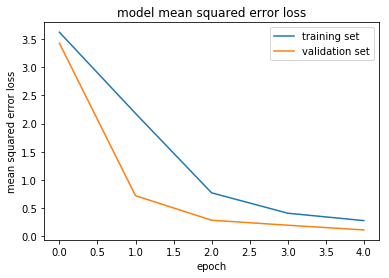

In [20]:
# Eğitim işleminin gidişatını grafik olarak görüyoruz
# Train and validation loss chart
print(hs.history.keys())

plt.plot(hs.history['loss'])
plt.plot(hs.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [21]:
# Eğittiğimiz modeli kaydediyoruz
# Ağ yapsını json olarak
# Ağ parametre değerlerini h5 uzantılı olarak
import json 
# Save model weights and json.
mname = 'model_new'
model.save_weights(mname+'.h5')
model_json  = model.to_json()
with open(mname+'.json', 'w') as outfile:
    json.dump(model_json, outfile)

In [22]:
# rastgele 10 resim seçip modelimiz hesapladığı sonuçla gerçeğine bakıyoruz 
# Eğer sonuçlar iyi ise kullanabiliriz
# Sonuççlar kötüyse eğitim aşamasına dönmemiz lazım
# Compare actual and predicted steering
#for i in range(10):
    #ix = random.randint(0,len(df)-1)
    #out = model.predict(get_matrix(df.image_name[ix]).reshape(1,376,1344,3))
    #print(df.angle[ix], ' - > ', out[0][0])